# Сверточный автоэнкодер

### Подготовка

In [1]:
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import Input
from keras.models import Sequential

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype('float32') / 255., x_test.astype('float32') / 255.

In [3]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    _n = min([x.shape[0] for x in args])

    plt.figure(figsize=(2 * _n, 2 * len(args)))
    for j in range(_n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), _n, i * _n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

Как мы убедились ранее, сверточные нейросети работают с изображениями лучше, чем обычные – из-за сохранения информации, данной природой данных. Отсюда логичное предположение, что сверточный автоэнкодер тоже будет лучше обрабатывать изображения и вычленять из них признаки. Давайте проверим.

In [4]:
def create_deep_conv_ae():
    encoder_functional = [
        Input(shape=(28, 28, 1)),
        Conv2D(64, (7, 7), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(16, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(1, (7, 7), activation='relu', padding='same')
    ]
    decoder_functional = [
        Input(shape=(7, 7, 1)),
        Conv2D(16, (7, 7), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(64, (2, 2), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(1, (28, 28), activation='sigmoid', padding='same')
    ]
    return Sequential(encoder_functional), Sequential(decoder_functional), Sequential(encoder_functional + decoder_functional)

In [6]:
c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
c_autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 16)        4112      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 1)           785       
                                                                 
 input_4 (InputLayer)        multiple                 

In [7]:
c_autoencoder.fit(x_train, x_train,
                  epochs=20,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test))

Epoch 1/20


2022-07-20 16:04:50.361200: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-20 16:04:50.681056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 0.1903

2022-07-20 16:06:11.578603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 89s 375ms/step - loss: 0.1903 - val_loss: 0.1139
Epoch 2/20
235/235 [==============================] - 88s 373ms/step - loss: 0.1086 - val_loss: 0.0989
Epoch 3/20
235/235 [==============================] - 88s 373ms/step - loss: 0.0974 - val_loss: 0.0928
Epoch 4/20
235/235 [==============================] - 87s 371ms/step - loss: 0.0923 - val_loss: 0.0894
Epoch 5/20
235/235 [==============================] - 87s 369ms/step - loss: 0.0895 - val_loss: 0.0862
Epoch 6/20
235/235 [==============================] - 87s 369ms/step - loss: 0.0870 - val_loss: 0.0845
Epoch 7/20
235/235 [==============================] - 87s 368ms/step - loss: 0.0855 - val_loss: 0.0846
Epoch 8/20
235/235 [==============================] - 88s 373ms/step - loss: 0.0842 - val_loss: 0.0819
Epoch 9/20
235/235 [==============================] - 88s 374ms/step - loss: 0.0831 - val_loss: 0.0810
Epoch 10/20
235/235 [==============================] - 88s 374ms/step - loss: 0.0821

1/1 [==============================] - 0s 84ms/step


2022-07-20 16:35:49.609657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


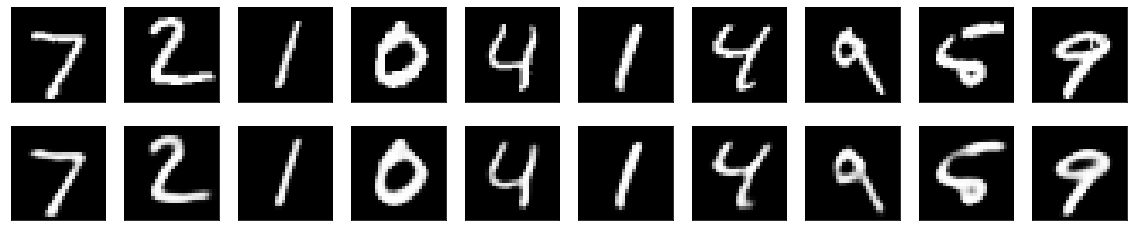

In [8]:
n = 10
imgs = x_test[:n]
plot_digits(imgs, c_autoencoder.predict(imgs, batch_size=n))

Как мы видим, сверточный автоэнкодер дает более плавную картинку, т.е. артефакты при использовании обычного глубокого автоэнкодера более точечные (как с 9кой в прошлом примере), а при сверточном – локально разнесенные.

# Denoising-автоэнкодер

Автоэнкодеры сжимают и выделяют ключевые признаки, поэтому его можно использовать в качестве фильтра шумов на фотографии: он все так же может выделять ключевые признаки, а потом восстанавливать изображение по ним – фильтровать шум.

In [9]:
import keras.backend as K
from keras.layers import Lambda

def to_denoising_ae(autoencoder, noise_factor=0.5):
    def _add_noise(x):
        _noised = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
        return K.clip(_noised, 0., 1.)

    noiser_functional = [
        Input(batch_shape=(16, 28, 28, 1)),
        Lambda(_add_noise)
    ]
    return Sequential(noiser_functional), Sequential(noiser_functional + autoencoder.layers)

In [12]:
noiser, denoiser_model = to_denoising_ae(create_deep_conv_ae()[2])
denoiser_model.compile(optimizer='adam', loss='binary_crossentropy')
denoiser_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (16, 28, 28, 1)           0         
                                                                 
 conv2d_24 (Conv2D)          multiple                  3200      
                                                                 
 max_pooling2d_8 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_25 (Conv2D)          multiple                  4112      
                                                                 
 max_pooling2d_9 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          multiple                

In [13]:
denoiser_model.fit(x_train, x_train,
                   epochs=1,
                   batch_size=16,
                   shuffle=True,
                   validation_data=(x_test, x_test))

2022-07-20 17:05:57.604897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3750/3750 [==============================] - ETA: 0s - loss: 0.1399

2022-07-20 17:07:59.079240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3750/3750 [==============================] - 133s 35ms/step - loss: 0.1399 - val_loss: 0.1174


1/1 [==============================] - 0s 11ms/step


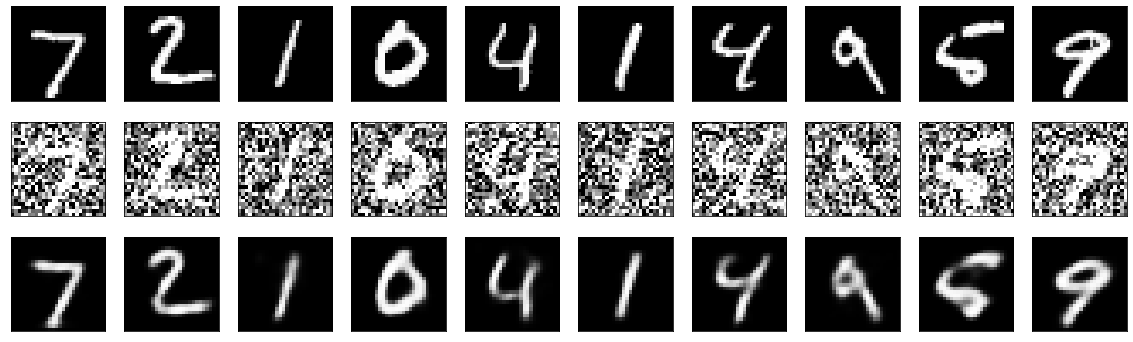

In [23]:
n = 10

imgs = x_test[:16]
noised_imgs = noiser.predict(imgs, batch_size=16)

plot_digits(imgs[:n], noised_imgs, denoiser_model.predict(imgs[:n], batch_size=10))

1/1 [==============================] - 0s 10ms/step
Epoch 1/2
3750/3750 [==============================] - 53s 14ms/step - loss: 0.1137 - val_loss: 0.1040
Epoch 2/2
1/1 [==============================] - 0s 10ms/step
Epoch 1/4
3750/3750 [==============================] - 0s 23us/step - loss: 0.1135 - val_loss: 0.1113
Epoch 2/4
3750/3750 [==============================] - 0s 15us/step - loss: 0.1248 - val_loss: 0.1101
Epoch 3/4
3750/3750 [==============================] - 0s 15us/step - loss: 0.1160 - val_loss: 0.1079
Epoch 4/4
1/1 [==============================] - 0s 9ms/step
Epoch 1/8
3750/3750 [==============================] - 0s 21us/step - loss: 0.1214 - val_loss: 0.1090
Epoch 2/8
3750/3750 [==============================] - 0s 15us/step - loss: 0.1119 - val_loss: 0.1023
Epoch 3/8
3750/3750 [==============================] - 0s 15us/step - loss: 0.1012 - val_loss: 0.1053
Epoch 4/8
3750/3750 [==============================] - 0s 15us/step - loss: 0.1147 - val_loss: 0.1059
Epoch 5/

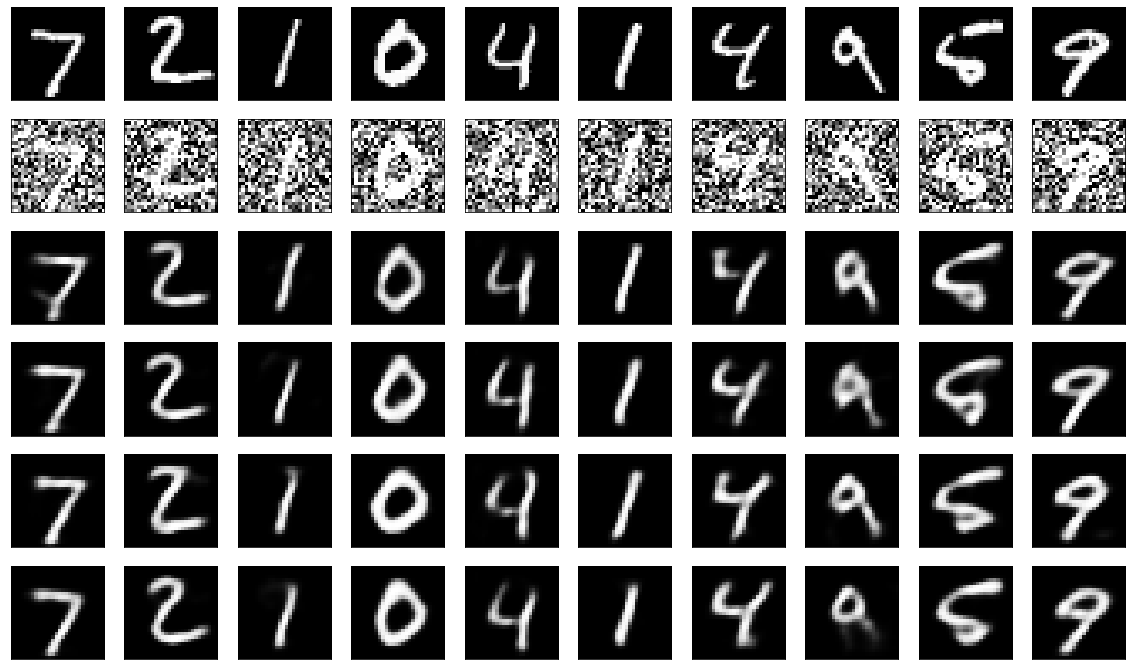

In [15]:
res = []

for epochs in [1, 2, 4, 8]:
    denoiser_model.fit(x_train, x_train,
                       epochs=epochs,
                       batch_size=16,
                       shuffle=True,
                       validation_data=(x_test, x_test))

    n = 10
    imgs = x_test[:16]
    res.append(denoiser_model.predict(imgs[:n], batch_size=10))

noised_imgs = noiser.predict(imgs, batch_size=16)
plot_digits(imgs[:n], noised_imgs, *res)

Различия между начальными цифрами и оцифрованным шумом очевидны, но, казалось бы, фильтрация действительно смогла обработать картинку так, что мы с вами можем распознать цифру на изображении без особого труда.

# Разреженный автоэнкодер

Можно посмотреть на сами картинки выше или на то, как менялась функция потерь с процессом обучения denoising-автоэнкодера, и сделать предположение о том, что на самом деле модель перестала в какой-то момент сильно обучатся, начали появляться точечные артефакты при декодировке. В целом, звучит это как попытка переобучения, но это не проблема – регуляризация в автоэнкодерах никуда не делась, а сами автоэнкодеры с регуляризацией приобрели наименование "разряженный автоэнкодер".

Давайте посмотрим на $l_1$-регуляризацию, но сначала поймем, а что вообще должна эта регуляризация пытаться ограничивать. Тут все просто: мы хотим, чтобы сеть выделяла как можно меньше признаков, которые бы были как можно более информативными, поэтому логично ставить регуляризацию только на последний слой энкодера.

In [16]:
from keras.regularizers import L1L2

def create_sparse_ae(lambda_l1 = 0.0001):
    encoder_functional = [
        Input(shape=(28, 28, 1)),
        Conv2D(64, (7, 7), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(16, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(1, (7, 7), activation='relu', padding='same', activity_regularizer=L1L2(lambda_l1))
    ]
    decoder_functional = [
        Input(shape=(7, 7, 1)),
        Conv2D(16, (7, 7), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(64, (2, 2), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(1, (28, 28), activation='sigmoid', padding='same')
    ]
    return Sequential(encoder_functional), Sequential(decoder_functional), Sequential(encoder_functional + decoder_functional)

In [17]:
s_encoder, s_decoder, s_autoencoder = create_sparse_ae()
s_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
s_autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10


2022-07-20 17:11:16.634124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 0.1970

2022-07-20 17:12:36.044410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 88s 372ms/step - loss: 0.1970 - val_loss: 0.1195
Epoch 2/10
235/235 [==============================] - 87s 370ms/step - loss: 0.1123 - val_loss: 0.1039
Epoch 3/10
235/235 [==============================] - 87s 370ms/step - loss: 0.1017 - val_loss: 0.0970
Epoch 4/10
235/235 [==============================] - 87s 370ms/step - loss: 0.0963 - val_loss: 0.0927
Epoch 5/10
235/235 [==============================] - 186s 795ms/step - loss: 0.0930 - val_loss: 0.0900
Epoch 6/10
235/235 [==============================] - 370s 2s/step - loss: 0.0907 - val_loss: 0.0879
Epoch 7/10
235/235 [==============================] - 2277s 10s/step - loss: 0.0888 - val_loss: 0.0874
Epoch 8/10
235/235 [==============================] - 5479s 23s/step - loss: 0.0872 - val_loss: 0.0850
Epoch 9/10
235/235 [==============================] - 87s 369ms/step - loss: 0.0860 - val_loss: 0.0838
Epoch 10/10
235/235 [==============================] - 1495s 6s/step - loss: 0.0848 -

1/1 [==============================] - 0s 71ms/step


2022-07-20 20:01:58.956351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


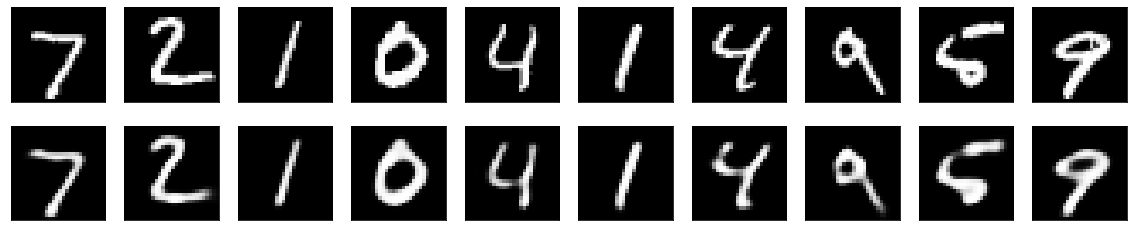

In [19]:
n = 10

imgs = x_test[:n]
plot_digits(imgs, s_autoencoder.predict(imgs, batch_size=n))

Как вы видите, автоэнкодер с регуляризацией справляется с задачей не хуже, чем обычный. Можем посмотреть на выход энкодера без регуляризации и с ней:

1/1 [==============================] - 0s 35ms/step


2022-07-20 20:01:59.264982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 20:01:59.312803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


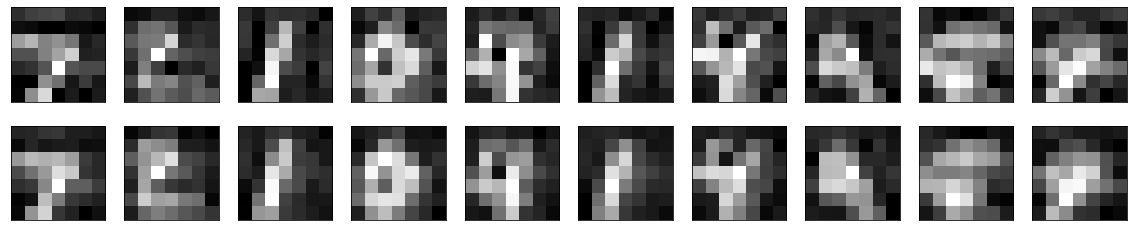

In [20]:
plot_digits(s_encoder.predict(imgs, batch_size=n), c_encoder.predict(imgs, batch_size=n))

In [21]:
s_encoder.predict(imgs, batch_size=n)

1/1 [==============================] - 0s 7ms/step


array([[[[2.10980967e-01],
         [2.90931851e-01],
         [3.15283805e-01],
         [3.37145567e-01],
         [1.83888420e-01],
         [2.00834677e-01],
         [1.38836384e-01]],

        [[7.04112649e-02],
         [5.46229221e-02],
         [0.00000000e+00],
         [0.00000000e+00],
         [5.37356623e-02],
         [4.10229824e-02],
         [1.48996804e-03]],

        [[7.17101932e-01],
         [8.26590598e-01],
         [5.97174942e-01],
         [6.64115429e-01],
         [5.39528430e-01],
         [1.10646509e-01],
         [1.82633743e-01]],

        [[3.75577211e-01],
         [3.71736884e-01],
         [5.92182815e-01],
         [7.46060312e-01],
         [9.50044870e-01],
         [1.50371075e-01],
         [1.64107367e-01]],

        [[1.91736370e-01],
         [2.28729784e-01],
         [3.87643456e-01],
         [1.16882312e+00],
         [3.86841297e-01],
         [3.34343761e-01],
         [3.33847493e-01]],

        [[0.00000000e+00],
         [0.000000

In [22]:
c_encoder.predict(imgs, batch_size=n)

1/1 [==============================] - 0s 7ms/step


array([[[[7.5648201e-01],
         [7.8768235e-01],
         [1.0483221e+00],
         [1.0921358e+00],
         [6.4575219e-01],
         [6.3738233e-01],
         [5.0835747e-01]],

        [[2.4966392e-01],
         [7.9259050e-01],
         [4.9411166e-01],
         [5.8148509e-01],
         [6.1793494e-01],
         [3.2959014e-01],
         [3.6666989e-01]],

        [[2.8746965e+00],
         [3.4795754e+00],
         [3.3241062e+00],
         [3.4693472e+00],
         [2.9868398e+00],
         [1.1718104e+00],
         [8.1801140e-01]],

        [[1.4660181e+00],
         [2.1752141e+00],
         [2.8920791e+00],
         [4.1629071e+00],
         [3.7754800e+00],
         [1.0691112e+00],
         [8.4548467e-01]],

        [[9.5835805e-01],
         [1.1404895e+00],
         [2.5578122e+00],
         [4.7732720e+00],
         [1.8328954e+00],
         [1.8061858e+00],
         [1.1795918e+00]],

        [[1.6302736e-01],
         [4.0400428e-01],
         [3.5448306e+00],
  

Как мы можем видеть, оба энкодера обучились кодировать изображение почти по-одинаковому, но при этом, энкодер с регуляризацией выдает значения в среднем на порядок меньше, чем энкодер без, что может сыграть какую-нибудь роль в других поставленных задачах, но, кажется, не в этой.
